In [2]:
import sys
sys.path.append('..')
from pipeline import CleaningPipe, ICAPipe, ResultsPipe

## Cleaning

In [3]:
pipe = CleaningPipe(
    path_to_eeg=r"C:\Users\Gennadiy\Documents\data\HZ4\HZ4_SLEEP_20210629_132715.mff",
    output_directory=r"C:\Users\Gennadiy\Documents\data\HZ4\processing")

Reading EGI MFF Header from C:\Users\Gennadiy\Documents\data\HZ4\HZ4_SLEEP_20210629_132715.mff...
    Reading events ...
    Assembling measurement info ...


### Resampling and filtering

In [4]:
pipe.resample(sfreq=250)

Resampling the data: 100%|##########| 264/264 [15:39<00:00,  3.56s/it]


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 2751 samples (11.004 sec)

Using CUDA for FFT FIR filtering
Setting up band-pass filter from 0.3 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-12 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 124.90 Hz
- Upper transition bandwidth: 0.10 Hz (-12 dB cutoff frequency: 124.95 Hz)
- Fil

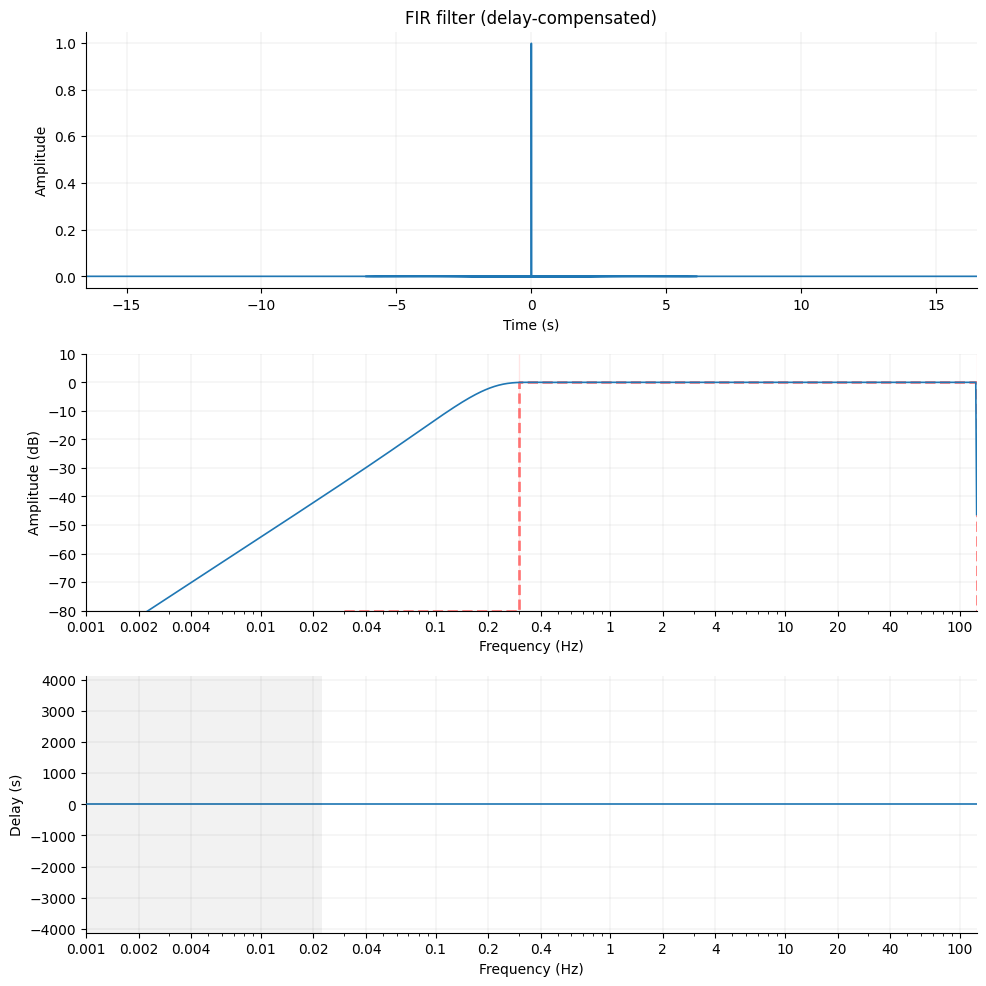

In [5]:
pipe.filter(l_freq=0.3)

In [6]:
pipe.notch()

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Using CUDA for FFT FIR filtering


### Select bad channels and epochs

In [7]:
pipe.mne_raw.set_eeg_reference(projection=True)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<RawMff | signal1.bin, 264 x 2229773 (8919.1 s), ~4.39 GB, data loaded>

Select bad channels

In [8]:
pipe.plot()

Using qt as 2D backend.
Channels marked as bad:
['E9', 'E156', 'E145', 'E111', 'E174', 'E216', 'E166', 'E187', 'E175', 'E186', 'E214', 'E46', 'E37', 'E93', 'E18', 'E181', 'E229', 'E165', 'E67', 'E2', 'E219', 'E218']


In [9]:
pipe.mne_raw.interpolate_bads(reset_bads=False)

Interpolating bad channels
    Automatic origin fit: head of radius 96.5 mm
Computing interpolation matrix from 235 sensor positions
Interpolating 22 sensors


<RawMff | signal1.bin, 264 x 2229773 (8919.1 s), ~4.39 GB, data loaded>

Select bad epochs

In [10]:
pipe.plot(butterfly=True)

Channels marked as bad:
['E9', 'E156', 'E145', 'E111', 'E174', 'E216', 'E166', 'E187', 'E175', 'E186', 'E214', 'E46', 'E37', 'E93', 'E18', 'E181', 'E229', 'E165', 'E67', 'E2', 'E219', 'E218']


## ICA

In [12]:
ica_pipe = ICAPipe(
    pipe=pipe,
    n_components=15)

In [13]:
ica_pipe.fit()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Using CUDA for FFT FIR filtering
Fitting ICA to data using 235 channels (please be patient, this may take a while)
Omitting 162057 of 2229773 (7.27%) samples, retaining 2067716 (92.73%) samples.
Selecting by number: 15 components
Fitting ICA took 77.4s.


In [14]:
ica_pipe.plot_sources()

Creating RawArray with float64 data, n_channels=16, n_times=2229773
    Range : 0 ... 2229772 =      0.000 ...  8919.088 secs
Ready.


c:\Users\Gennadiy\Documents\eeg-processing-pipeline\notebooks\..\pipeline.py:157: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.mne_ica.plot_sources(self.mne_raw, block=True)


In [16]:
ica_pipe.apply(exclude=[9])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 235 PCA components


## Results

In [17]:
results_pipe = ResultsPipe(
    pipe=ica_pipe,
    path_to_hypno=r"C:\Users\Gennadiy\Documents\data\HZ4\staging.txt",
    sf_hypno=1)

12-Feb-23 15:05:38 | WARNING | Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


Setting 162057 of 2229773 (7.27%) samples to NaN, retaining 2067716 (92.73%) samples.


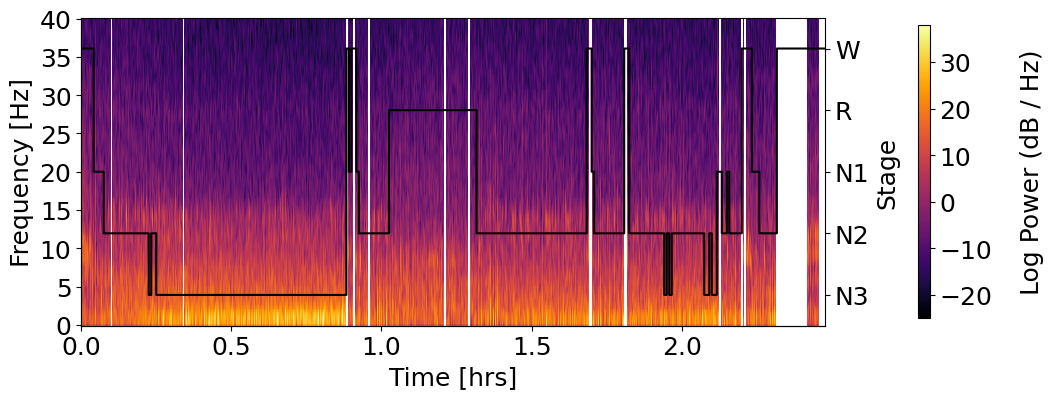

In [19]:
results_pipe.plot_hypnospectrogram(
    picks=['E101'],
    win_sec=4,
    freq_range=(0, 40),
    cmap='inferno',
    overlap=True)

Setting 162057 of 2229773 (7.27%) samples to NaN, retaining 2067716 (92.73%) samples.


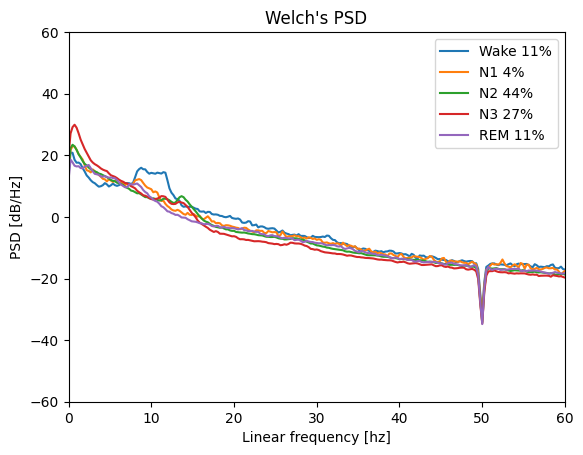

In [20]:
results_pipe.plot_psd_per_stage(
    picks=['E101'], 
    sec_per_seg=4.096,
    psd_range=(-60, 60),
    freq_range=(0, 60),
    xscale='linear',
    sleep_stages={'Wake' :0, 'N1' :1, 'N2': 2, 'N3': 3, 'REM': 4})

In [21]:
results_pipe.sleep_stats()

{'TIB': 148.66666666666666,
 'SPT': 136.5,
 'WASO': 5.5,
 'TST': 131.0,
 'N1': 6.5,
 'N2': 65.5,
 'N3': 41.5,
 'REM': 17.5,
 'NREM': 113.5,
 'SOL': 2.5,
 'Lat_N1': 2.5,
 'Lat_N2': 4.5,
 'Lat_N3': 13.5,
 'Lat_REM': 61.5,
 '%N1': 4.961832061068702,
 '%N2': 50.0,
 '%N3': 31.6793893129771,
 '%REM': 13.358778625954198,
 '%NREM': 86.6412213740458,
 'SE': 88.11659192825113,
 'SME': 95.97069597069597}